In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P1')

Mounted at /content/drive


In [2]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

## ignore warnings
import warnings
warnings.filterwarnings("ignore",module = "matplotlib\..*")

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
## Load data
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,Happy,delivered_on_time,contents_as_expected,ordered_everything_I_wanted,paid_a_good_price,satisfied_with_my_courier,app_makes_ordering_easy
0,0,0,3,3,3,4,2,4
1,1,0,3,2,3,5,4,3
2,2,1,5,3,3,3,3,5
3,3,0,5,4,3,3,3,5
4,4,0,5,4,3,3,3,5


In [4]:
data = data.drop('Unnamed: 0',axis=1)
data.columns

Index(['Happy', 'delivered_on_time', 'contents_as_expected',
       'ordered_everything_I_wanted', 'paid_a_good_price',
       'satisfied_with_my_courier', 'app_makes_ordering_easy'],
      dtype='object')

In [5]:
## split the data frame into the response variable, y, and the design matrix, X
df = data.copy()
y = df['Happy'] ## response 
X = df.drop('Happy',axis=1) ## design matrix
from sklearn.model_selection import train_test_split
# split the data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.1, ## we will leave 10% to test our models on later. We have a small dataset so we need as many data to train on as possible.
                                                    random_state=42, ## make our work reproducible
                                                    shuffle=True,  ## prevent data ordering affecting our models
                                                    stratify = y)

In [6]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True, # tell us what is happening
            early_stopping_rounds=10, # stop building trees, when they no longer improve the situation
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.83238
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.83238
[2]	validation_0-aucpr:0.77095
[3]	validation_0-aucpr:0.77095
[4]	validation_0-aucpr:0.77095
[5]	validation_0-aucpr:0.77095
[6]	validation_0-aucpr:0.77095
[7]	validation_0-aucpr:0.77095
[8]	validation_0-aucpr:0.680051
[9]	validation_0-aucpr:0.680051
[10]	validation_0-aucpr:0.680051
Stopping. Best iteration:
[0]	validation_0-aucpr:0.83238



XGBClassifier(seed=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


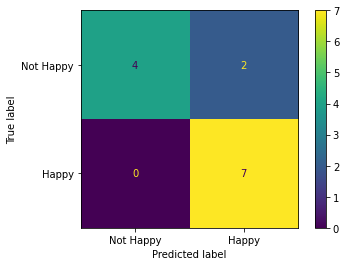

In [7]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Not Happy','Happy'])

In [12]:
param_grid = {'max_depth' : [3,4,5,10,15],
'learning_rate' : [0.01, 0.05, 0.1],
'gamma' : [0, 0.25, 0.5], # controls pruning
'reg_lambda' : [0,1,5,100], # reg param
'scale_pos_weight' : [1,2,3] # xgb recommends sum(neg instances)/sum(pos instances)
}

In [13]:
## To speed up cv and prevent overfitting:
## We are only using a random subset of the data and 
## a random subset of the features

opt_params = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic',
					                                              seed=42,
					                                              subsample=0.9,  # to avoid overfitting
					                                              colsample_bytree=0.5),  # to avoid overfitting
				                  param_grid=param_grid, 
				                  scoring='roc_auc',
				                  verbose=0, # 2 to see what is doing
				                  cv=10)
		

In [14]:
opt_params.fit(X_train,
            y_train,
            verbose=False, # don't tell us what is happening
            early_stopping_rounds=10, # stop building trees, when they no longer improve the situation
            eval_metric='auc',
            eval_set=[(X_test,y_test)])
print(opt_params.best_params_)

{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'reg_lambda': 1, 'scale_pos_weight': 3}


In [15]:
opt_dict = opt_params.best_params_
gamma, learning_rate, max_depth, reg_lambda, scale_pos_weight = opt_dict.values()

In [ ]:
# import pickle

# # Saving the params:
# with open('params.pkl', 'wb') as f:
#     pickle.dump([gamma, learning_rate, max_depth, reg_lambda, scale_pos_weight], f)

In [ ]:
# # Getting back the params:
# with open('params.pkl', 'rb') as f:  
#      gamma, learning_rate, max_depth, reg_lambda, scale_pos_weight = pickle.load(f)

In [16]:
clf_xgb = xgb.XGBClassifier(seed=42,
				objective='binary:logistic',
				gamma=gamma,
				learn_rate=learning_rate,
				max_depth=max_depth,
				reg_lambda=reg_lambda,
				scale_pos_weight=scale_pos_weight,
				subsample=.9,
				colsample_bytree=0.5)

clf_xgb.fit(X_train,
y_train,
verbose=True,
early_stopping_rounds=10,
eval_metric='aucpr',
eval_set=[(X_test,y_test)])


[0]	validation_0-aucpr:0.746163
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.746163
[2]	validation_0-aucpr:0.839855
[3]	validation_0-aucpr:0.825279
[4]	validation_0-aucpr:0.793836
[5]	validation_0-aucpr:0.793836
[6]	validation_0-aucpr:0.793836
[7]	validation_0-aucpr:0.793836
[8]	validation_0-aucpr:0.793836
[9]	validation_0-aucpr:0.793836
[10]	validation_0-aucpr:0.793836
[11]	validation_0-aucpr:0.793836
[12]	validation_0-aucpr:0.793836
Stopping. Best iteration:
[2]	validation_0-aucpr:0.839855



XGBClassifier(colsample_bytree=0.5, learn_rate=0.01, max_depth=10,
              scale_pos_weight=3, seed=42, subsample=0.9)

In [58]:
## from the feature selection method in the random forest model file 
## we drop all cols except delivered_on_time

cols2drop = ['ordered_everything_I_wanted','paid_a_good_price','contents_as_expected','satisfied_with_my_courier','app_makes_ordering_easy']
data2 = data.copy()
data2.drop(cols2drop, axis=1, inplace=True)

In [59]:
# data2[data2['delivered_on_time']==1]
# data2.drop(index=47,inplace=True)

For XGBoost removing the single entry which has a rating of 1 for 'delivered_on_time' drops the accuracy from 77% to 53%.

In [60]:
## split the data frame into the response variable, y, and the design matrix, X
df = data2.copy()
y = df['Happy'] ## response 
X = df.drop('Happy',axis=1) ## design matrix
from sklearn.model_selection import train_test_split
# split the data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, ## features to split
                                                    y, ## response to split
                                                    test_size=0.1, ## we will leave 10% to test our models on later. We have a small dataset so we need as many data to train on as possible.
                                                    random_state=42, ## make our work reproducible
                                                    shuffle=True,  ## prevent data ordering affecting our models
                                                    stratify = y)

In [61]:
opt_params = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic',
					                                              seed=42,
					                                              subsample=0.9,          # to avoid overfitting
					                                              colsample_bytree=0.5),  # to avoid overfitting
				                  param_grid=param_grid,
				                  scoring='roc_auc',
				                  verbose=0, # 2 to see what is doing
				                  cv=10)

In [62]:
opt_params.fit(X_train,
            y_train,
            verbose=False, # don't tell us what is happening
            early_stopping_rounds=10, # stop building trees, when they no longer improve the situation
            eval_metric='auc',
            eval_set=[(X_test,y_test)])
print(opt_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 100, 'scale_pos_weight': 1}


In [63]:
opt_dict = opt_params.best_params_
gamma, learning_rate, max_depth, reg_lambda, scale_pos_weight = opt_dict.values()

In [64]:
clf_xgb = xgb.XGBClassifier(seed=42,
				objective='binary:logistic',
				gamma=gamma,
				learn_rate=learning_rate,
				max_depth=max_depth,
				reg_lambda=reg_lambda,
				scale_pos_weight=scale_pos_weight,
				subsample=.9,
				colsample_bytree=0.5)

In [65]:
clf_xgb.fit(X_train,
y_train,
verbose=True,
early_stopping_rounds=10,
eval_metric='aucpr',
eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.732464
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.732464
[2]	validation_0-aucpr:0.732464
[3]	validation_0-aucpr:0.732464
[4]	validation_0-aucpr:0.732464
[5]	validation_0-aucpr:0.732464
[6]	validation_0-aucpr:0.732464
[7]	validation_0-aucpr:0.732464
[8]	validation_0-aucpr:0.732464
[9]	validation_0-aucpr:0.732464
[10]	validation_0-aucpr:0.732464
Stopping. Best iteration:
[0]	validation_0-aucpr:0.732464



XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.01, reg_lambda=100,
              seed=42, subsample=0.9)

In [66]:
y_pred = clf_xgb.predict(X_test)

In [67]:
#Accuracy
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.92%
